# News Classifier Quickstart

The code should run out of the box if the following dependencies are installed:
```
# dependencies:
# pytorch
# transformers
# safetensors
```
The models are packaged in the `news_clf` subdirectory. The mode classes handle tokenization to the training length (1500 tokens) and calculation of class scores (ordinal model only) and class probabilities from the base model outputs.

The base model is `microsoft/deberta-v3-xsmall`. The "`xsmall`" model specification is actually the same size as `deberta-v3-small`, but trades breadth for depth (smaller embeddings, deeper network), which should work better given the abstract nature of the target categories. More depth allows the article information to be integrated across a larger range.

In [1]:
# coerce cpu

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"


In [2]:
from news_clf import ( PretrainedModelForOrdinalSequenceClassification, 
                       PretrainedModelForUnorderedSequenceClassification )

device_map = 'cpu' # set to 'auto' to use gpu if available

2025-06-12 21:54:47.858958: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 21:54:47.881013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749779687.894670  354611 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749779687.903178  354611 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749779687.957912  354611 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Load in the two model versions

The two models perform comparably but the ordinal model edges out the 3-discrete class model by about .1% accuracy. Both achieve about 89% accuracy and can be used for probabilities, but only the ordinal model returns a one-dimensional score for the articles.

In [3]:
checkpoint_3class = '3class_model_best_checkpoint.safetensors' # accuracy for the 3class model is .8957
clf_3class = PretrainedModelForUnorderedSequenceClassification(device_map=device_map, checkpoint=checkpoint_3class)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/matthias/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [4]:
checkpoint_ordinal = 'ordinal_model_best_checkpoint.safetensors' # accuracy for the ordinal model is .8973
clf_ordinal = PretrainedModelForOrdinalSequenceClassification(device_map=device_map, checkpoint=checkpoint_ordinal)

/home/matthias/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Processing an article

Use the `classify_article` method with a title and body (the model requires both, if there is no title input the empty string `''`). Articles are truncated to a maximum of 1,500 tokens.

In [5]:
import pandas as pd

# load in the training data
df_framing_annotations = pd.read_csv('Dataset-framing_annotations-Llama-3.3-70B-Instruct-Turbo.csv')

#### Summary statistics for the training dataset

The neural network model was trained and evaluating using **125,014 news articles** obtained from NewsApi.ai Event Registry. The training data were obtained using a set of keyword searches for terms representing current events, event-types, and figures that were likely to have balanced distributions of neutral-, loaded-, and alarmist-framing, with the annotation model instructed to classify articles on the basis of the nature of the framing rather than that of the events themselves. Topics were selected so as to reflect areas of controversy in current reporting so as to maximize the amount of reporting reflecting loaded or alarmist framing, as well as generic event types likely to elicit the same. The **149 topic categories** with associated number of articles are reported in the following figure:

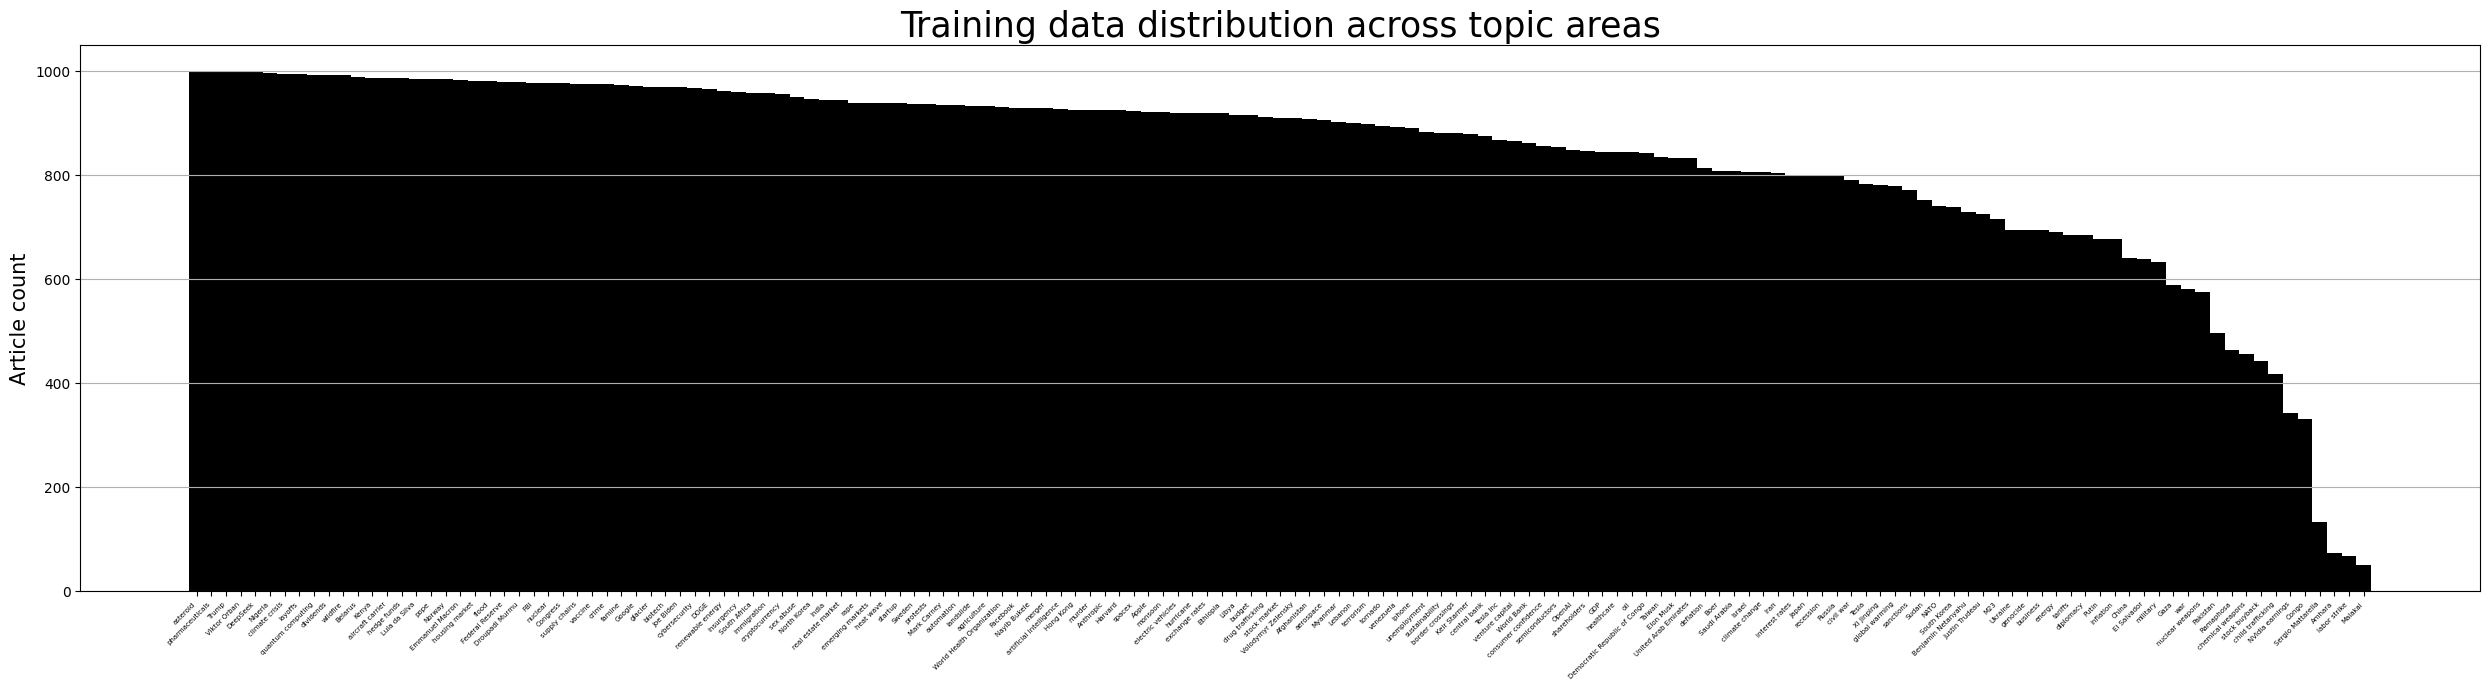

In [6]:
import matplotlib.pyplot as plt

topic_counts = df_framing_annotations.concept.value_counts().reset_index()

topics = topic_counts.concept
counts = topic_counts['count']

fig, ax = plt.subplots(1,1, figsize=(25,7))
ax.bar(range(topics.shape[0]), counts, color='k', edgecolor='k', linewidth=0, width=1)
ax.set_ylabel('Article count', fontsize=15)
ax.set_xticks(range(topics.shape[0]))
_ = ax.set_xticklabels(topics, rotation=45, ha='right', fontsize=5)

ax.grid(axis='y')
ax.set_title('Training data distribution across topic areas', fontsize=25)
fig.tight_layout()

fig.savefig('topics_distribution.png', dpi=500)

#### Model training protocol

Articles were annotated with discrete class labels (Neutral, Loaded, and Alarmist) by an annotator model (Llama 3.3, 70 billion parameters). To render the discrete labels from the teacher model into alarmism scores that reflect degrees of alarmist/loaded framing per article, lend themsleves to statistical analysis, and which can be run locally, we trained a smaller neural network based on the Deberta architecture (https://github.com/microsoft/DeBERTa). 1/40 articles (3k) were held-out for evaluation/model selection with the networks trained on the remaining 122k.

Two versions of the model were trained, one using a standard softmax classification head that outputs probabilities for each of the three classes, as well as an ordinal classification head that computes probability of each class based on a projection of the neural network's representation of the article onto a single linear dimension representing the article's position on a linear scale where lower values indicate neutrality and higher values indicating a greater amount of alarmism. Both models performed comparably on the task, with **90.1%** accuracy from the softmax classifier and **89.7%** for the ordinal model.

#### A neutral article:

In [7]:
# select an article to run
from news_clf.text_utils import shorten_to_n_words
import numpy as np

target = 'NEUTRAL'
i = np.random.choice(np.where(df_framing_annotations.FRAMING_CLASS == target)[0])
example = df_framing_annotations.iloc[i]

print(example.source)
print(example.title)
print(shorten_to_n_words(example.body, 250))

print('\nAnnotation:', example.FRAMING_CLASS)
print('\n3-class softmax model:')
print(clf_3class.classify_article(example.title, example.body))

print('Ordinal model:')
print(clf_ordinal.classify_article(example.title, example.body))

{'uri': 'nhpr.org', 'dataType': 'news', 'title': 'New Hampshire Public Radio'}
Refresher Course: Does Congress still hold the power of the purse?
Every other Tuesday, the team behind Civics 101 joins NHPR's All Things Considered Host Julia Furukawa to talk about how our democratic institutions actually work.

Since President Donald Trump took office, he's tried to freeze federal funding for grants, foreign aid and more, but some of those actions have been challenged in court. Congress is supposed to dictate how the government spends money. So how is the president able to spend or freeze funds?

Civics 101 host Nick Capodice joined Julia to talk about the power of the purse and if Congress still holds that power today.

First off, though, Nick, can you give us some classic 101 on this? What are the powers Congress has to check the president specifically?

There are four ways. Before I rattle them off, it's worth mentioning that checks and balances are the core of our governmental system

#### A loaded article:

In [8]:
target = 'LOADED'
i = np.random.choice(np.where(df_framing_annotations.FRAMING_CLASS == target)[0])
example = df_framing_annotations.iloc[i]

print(example.source)
print(example.title)
print(shorten_to_n_words(example.body, 250))

print('\nAnnotation:', example.FRAMING_CLASS)
print('\n3-class softmax model:')
print(clf_3class.classify_article(example.title, example.body))

print('Ordinal model:')
print(clf_ordinal.classify_article(example.title, example.body))

{'uri': 'cbsnews.com', 'dataType': 'news', 'title': 'CBS News'}
Donald Trump Jr.'s transformation into Washington power broker
When the crypto mining firm American Bitcoin announced plans to go public on the Nasdaq stock exchange this week, the company called it a "major milestone" for a key stakeholder, Dominari Holdings -- a little-known investment house that recently added a very recognizable name to its advisory board: Donald Trump Jr.

It was the latest maneuver in a series of high-stakes, and potentially lucrative business deals Trump Jr. and his younger brother Eric, also a Dominari adviser, stand to benefit from.

Since his father won the 2024 election, Trump Jr. has joined at least eight corporate boards or advisory committees, adding political clout and his famous family brand to companies that sell handguns, make drones, and offer healthcare services online.

During President Trump's second term, his son Donald Jr. has morphed from a lower profile presence in Washington to a

#### An alarmist article:

In [9]:
target = 'ALARMIST'
i = np.random.choice(np.where(df_framing_annotations.FRAMING_CLASS == target)[0])
example = df_framing_annotations.iloc[i]

print(example.source)
print(example.title)
print(shorten_to_n_words(example.body, 250))

print('\nAnnotation:', example.FRAMING_CLASS)
print('\n3-class softmax model:')
print(clf_3class.classify_article(example.title, example.body))

print('Ordinal model:')
print(clf_ordinal.classify_article(example.title, example.body))

{'uri': 'rollingstone.com', 'dataType': 'news', 'title': 'Rolling Stone'}
Lawyers Say Trump Is Trying to Send Asian Immigrants to Libya
Musk Allies Made FAA Staff Sign NDAs to Keep New Project Secret

Donald Trump's administration is working to ramp up its pointless cruelty toward immigrants, and has apparently been plotting to have the military send Asian immigrants to Libya imminently, according to immigration lawyers.

The plan to deport immigrants to Libya, a war-torn country known for widespread mistreatment of migrants, would represent not just a likely human rights violation but another brazen act of defiance toward the federal judiciary.

Last month, a federal judge in Massachusetts issued an injunction barring the Trump administration from deporting any noncitizen to a third country -- a country that is not their country of origin -- without due process, and without giving them a meaningful opportunity to demonstrate they fear being persecuted, tortured, or killed if they are 

#### An article about tariffs

In [10]:
i = np.random.choice(np.where(df_framing_annotations.concept == 'tariffs')[0])
example = df_framing_annotations.iloc[i]

print(example.source)
print(example.title)
print(shorten_to_n_words(example.body, 250))

print('\nAnnotation:', example.FRAMING_CLASS)
print('\n3-class softmax model:')
print(clf_3class.classify_article(example.title, example.body))

print('Ordinal model:')
print(clf_ordinal.classify_article(example.title, example.body))

{'uri': 'sandiegouniontribune.com', 'dataType': 'news', 'title': 'San Diego Union-Tribune'}
Did Walmart make the right move warning customers about higher prices?
Walmart made the rare move recently of warning customers, and investors, that it will begin raising prices as the result of tariffs.

The retail giant said even with recent reductions in tariffs, it still had no choice but to pass some costs onto consumers.

Other companies have also warned consumers, such as Procter & Gamble and Hasbro, but some experts say it will be less obvious. Amazon said it considered displaying import charges (like Chinese retailer Temu) but ultimately decided against it.

There was some blowback to Walmart's announcement, with some of President Donald Trump's most ardent supporters accusing the company of greed and using tariffs as an excuse.

Question: Did Walmart make the right move warning customers about higher prices?

YES: Walmart operates in a competitive retail market so fully absorbing the c

In [ ]:
# plot the class probabilities
